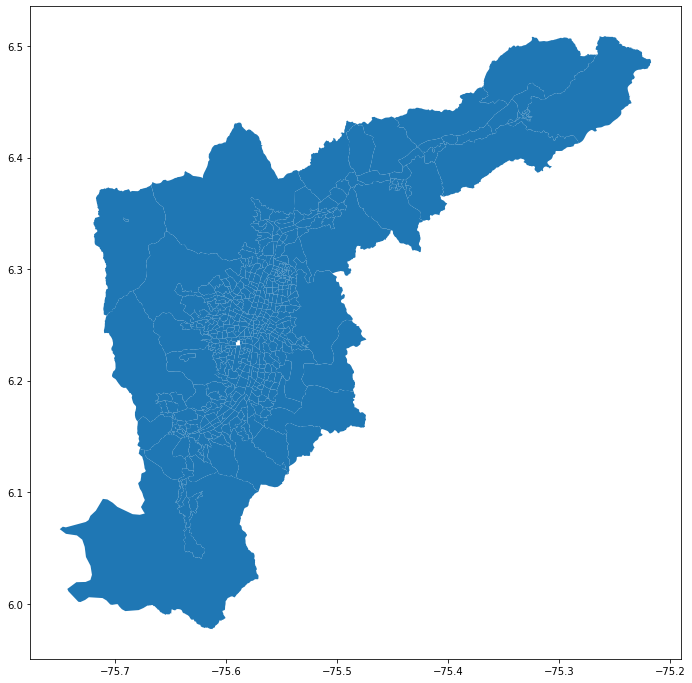

In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from shapely.ops import cascaded_union
from shapely.geometry import Polygon
%matplotlib inline

aburra_valley = gp.read_file("maps/EOD.shp")
# Plotting
aburra_valley.plot(figsize=(12, 12))
plt.show()

In [2]:
print(aburra_valley.head())

  SIT_2017  Ejemplo_EO SIT_Urban  \
0      372      1409.9     URBAN   
1      364       402.8     URBAN   
2      618       491.1     URBAN   
3      613       730.0     URBAN   
4      125      7218.8     URBAN   

                                            geometry  
0  POLYGON ((-75.56230213752727 6.328748454069691...  
1  POLYGON ((-75.55033011256714 6.329386326746962...  
2  POLYGON ((-75.49851285956038 6.358192179318264...  
3  POLYGON ((-75.52777093976739 6.307813882886017...  
4  POLYGON ((-75.53838829881064 6.248307776749133...  


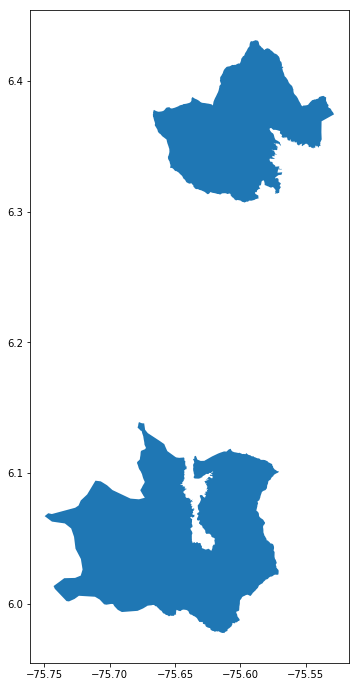

In [3]:
# Reduce small places
to_eliminate = []
for index, row in aburra_valley.iterrows():
    if row['geometry'].area < 5.5e-3:
        to_eliminate.append(index)

aburra_less = aburra_valley.drop(to_eliminate, axis=0)
aburra_less.plot(figsize=(12, 12))
plt.show()

In [ ]:
# Create aburra merged
aburra_merged = aburra_valley.unary_union #aburra_less.unary_union

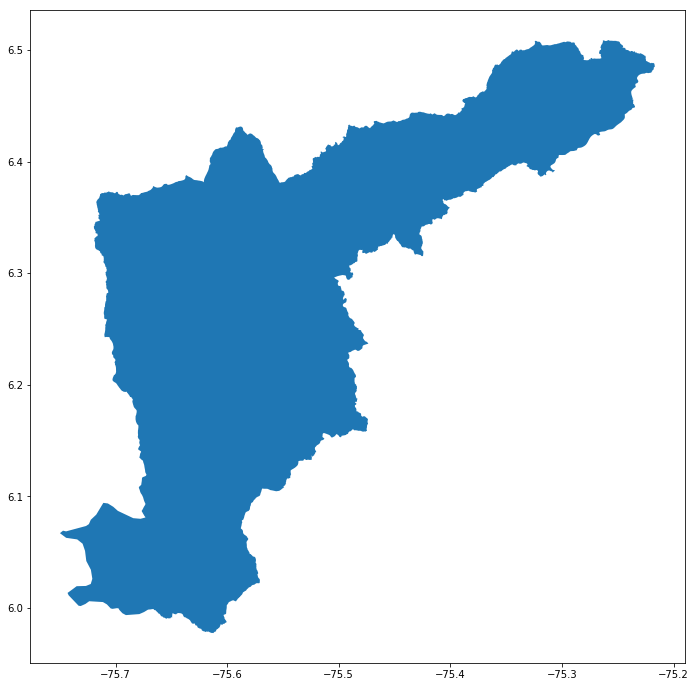

In [9]:
aburra_valley_polygon = aburra_merged #list(aburra_merged)[0]
x, y = aburra_valley_polygon.exterior.coords.xy
coord = np.dstack((x, y)).tolist()

plotting = False
if plotting:
    for i in range(len(coord[0]) - 1):
        plt.plot((coord[0][i][0], coord[0][i + 1][0]), (coord[0][i][1], coord[0][i + 1][1]), 'k')

    plt.show()
    
border_valley = gp.GeoSeries(Polygon(coord[0]))
border_valley.plot(figsize=(12, 12))
plt.show()

border_valley.to_file("maps/EOD_border.shp", driver="ESRI Shapefile")

In [18]:
aburra_valley

,SIT_2017,Ejemplo_EO,SIT_Urban,geometry,neighbors
0,372,1409.9,URBAN,"POLYGON ((-75.56230 6.32875, -75.56119 6.32764...","364, 374, 373, 352, 371"
1,364,402.8,URBAN,"POLYGON ((-75.55033 6.32939, -75.55106 6.32821...","372, 414, 413, 373, 362, 365, 415, 363, 371"
2,618,491.1,URBAN,"POLYGON ((-75.49851 6.35819, -75.49854 6.35816...","347, 614, 611, 619, 346, 410"
3,613,730.0,URBAN,"POLYGON ((-75.52777 6.30781, -75.52716 6.30754...","320, 1, 348, 353"
4,125,7218.8,URBAN,"POLYGON ((-75.53839 6.24831, -75.53839 6.24832...","320, 132, 126"
...,...,...,...,...,...
507,342,2441.2,URBAN,"POLYGON ((-75.45224 6.37431, -75.45232 6.37427...","345, 344, 343, 627"
508,607,722.4,URBAN,"POLYGON ((-75.69077 6.34502, -75.68995 6.34425...",325
509,616,482.3,URBAN,"POLYGON ((-75.63152 6.13003, -75.63155 6.12998...","615, 441, 439, 408, 617"
510,341,4839.6,URBAN,"POLYGON ((-75.44601 6.38110, -75.44554 6.38069...","340, 345, 344, 627, 338"


In [17]:
aburra_valley["neighbors"] = None  # add NEIGHBORS column
print(aburra_valley.iterrows())
for index, zone in aburra_valley.iterrows():   
    # get 'not disjoint' countries
    neighbors = aburra_valley[~aburra_valley.geometry.disjoint(zone.geometry)].SIT_2017.tolist()

    # remove own name from the list
    neighbors = [ name for name in neighbors if zone.SIT_2017 != name ]

    # add names of neighbors as NEIGHBORS value
    aburra_valley.at[index, "neighbors"] = ", ".join(neighbors)

<generator object DataFrame.iterrows at 0x7fe0c85c24a0>


In [19]:
file = open("eod.map", "w")
file.write(str(aburra_merged.wkt) + "\n")
for index, zone in aburra_valley.iterrows():
    file.write(str(zone.geometry.wkt) + " | ")
    file.write(str(zone.SIT_2017) + " | ")
    file.write(zone.neighbors + "\n")